In [ ]:
cd '/content/drive/MyDrive/HEXR/Code/VIME'

/content/drive/MyDrive/HEXR/Code/VIME


In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# import supervised_models
# import self_learning
# import utils
# from supervised_models import logit, mlp
# from utils import mask_generator, pretext_generator
# from self_learning import vime_self
# from utils import perf_metric

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend

#to load VIME original

from supervised_models import logit, mlp
from vime_utils import mask_generator, pretext_generator
from vime_self import vime_self
from vime_utils import perf_metric

## Load CASE dataset

In [ ]:
#Run this cell for CASE

df = pd.read_csv('/content/drive/MyDrive/HEXR/Data/CASE_2class.csv')

ohe = OneHotEncoder()
#Choose either class1 or class2 to select either valence or arousal
df_ohe = pd.DataFrame(ohe.fit_transform(df[['class2']]).toarray())
df = df.join(df_ohe)

df.drop('class1', axis=1, inplace=True)
df.drop('class2', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('valence', axis=1, inplace=True)
df.drop('arousal', axis=1, inplace=True)
X = df.loc[:,:'emg_trap']
y = df.iloc[:,8:]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X[['ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']] = scaler.fit_transform(X[['ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']])


from sklearn.model_selection import train_test_split

"""
Split used in accordance with VIME @ Neurips 2020 for comparison:
15% :- Test 
10% of 85% = 8.5% :- Labelled dataset
90% of 85% = 76.5% :- Unlabelled dataset
"""
X_L, X_U, y_L, y_test = train_test_split(X,y,test_size=0.15,random_state=7) 

#converting to numpy arrays
X_L = X_L.iloc[:, :].values
y_L = y_L.iloc[:, :].values
X_U = X_U.iloc[:,:].values
y_test = y_test.iloc[:,:].values
X_L.shape, X_U.shape, y_L.shape, y_test.shape


x_train = X_L
y_train = y_L
x_test = X_U
y_test = y_test

In [ ]:
# Experimental parameters
label_no = 1000  
model_sets = ['logit','mlp']

#reconstuction loss is log cosh
#recon_loss = log_cosh

# Hyper-parameters
p_m = 0.3
alpha = 2.0
K = 3
beta = 1.0
label_data_rate = 0.1

# Metric
metric1 = 'acc'
metric2 = 'auc'
  
# Define output
results = np.zeros([len(model_sets)+2])

In [ ]:
# Divide labeled and unlabeled data
idx = np.random.permutation(len(y_train))

# Label data : Unlabeled data = label_data_rate:(1-label_data_rate)
label_idx = idx[:int(len(idx)*label_data_rate)]
unlab_idx = idx[int(len(idx)*label_data_rate):]

# Unlabeled data
x_unlab = x_train[unlab_idx, :]

# Labeled data
x_train = x_train[label_idx, :] 
y_train = y_train[label_idx, :]

In [ ]:
len(x_unlab)

1125285

In [ ]:
# Self supervised training of encoder - 90% of train data.

mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 128
  
# Train VIME-Self
vime_self_parameters = dict()
vime_self_parameters['batch_size'] = 128
vime_self_parameters['epochs'] = 15
vime_self_encoder = vime_self(x_unlab, p_m, alpha, vime_self_parameters)
    
# Save encoder
if not os.path.exists('save_model'):
  os.makedirs('save_model')

file_name = '../save_model/CASE_encoder.h5'
    
vime_self_encoder.save(file_name)  

Epoch 1/15
8792/8792 [==============================] - 34s 3ms/step - loss: 0.6348 - mask_loss: 0.6130 - feature_loss: 0.0109
Epoch 2/15
8792/8792 [==============================] - 31s 4ms/step - loss: 0.6265 - mask_loss: 0.6107 - feature_loss: 0.0079
Epoch 3/15
8792/8792 [==============================] - 31s 4ms/step - loss: 0.6260 - mask_loss: 0.6103 - feature_loss: 0.0079
Epoch 4/15
8792/8792 [==============================] - 34s 4ms/step - loss: 0.6255 - mask_loss: 0.6098 - feature_loss: 0.0079
Epoch 5/15
8792/8792 [==============================] - 31s 4ms/step - loss: 0.6251 - mask_loss: 0.6094 - feature_loss: 0.0079
Epoch 6/15
8792/8792 [==============================] - 30s 3ms/step - loss: 0.6249 - mask_loss: 0.6091 - feature_loss: 0.0079
Epoch 7/15
8792/8792 [==============================] - 30s 3ms/step - loss: 0.6248 - mask_loss: 0.6090 - feature_loss: 0.0079
Epoch 8/15
8792/8792 [==============================] - 31s 3ms/step - loss: 0.6247 - mask_loss: 0.6089 - featu

In [ ]:
logistic_supervised_acc = []
logistic_supervised_auc = []
mlp_supervised_acc = []
mlp_supervised_auc = []
self_supervised_acc = []
self_supervised_auc = []

mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 128

# from keras.models import load_model
# vime_self_encoder = load_model('../save_model/CASE_encoder.h5')

for label_no in tqdm([1000,20000,40000,60000,80000,100000, len(label_idx)]):
  x_t = x_train[:label_no, :]
  y_t = y_train[:label_no, :]  

  y_test_hat = logit(x_t, y_t, x_test)
  logistic_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
  logistic_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

  y_test_hat = mlp(x_t, y_t, x_test, mlp_parameters)
  mlp_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
  mlp_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

  # Test VIME-Self
  x_train_hat = vime_self_encoder.predict(x_t)
  x_test_hat = vime_self_encoder.predict(x_test)
        
  y_test_hat = mlp(x_train_hat, y_t, x_test_hat, mlp_parameters)
  self_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
  self_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

  0%|          | 0/7 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch: 24.
Epoch 74: early stopping


100%|██████████| 7/7 [27:13<00:00, 233.42s/it]


In [ ]:
# logistic_supervised_acc

[0.6795879335037436,
 0.6766963978172984,
 0.6766012218777759,
 0.6764335309367125,
 0.6764833850002719,
 0.6763791446855568,
 0.6765332390638313]

In [ ]:
# mlp_supervised_auc

[0.6294707808777823,
 0.7750982561010138,
 0.829857962936672,
 0.8421998206210648,
 0.8640369392360756,
 0.8682568521240643,
 0.8666504009550444]

In [ ]:
# mlp_supervised_acc

[0.6614818440564891,
 0.7407316763655482,
 0.7778774859048966,
 0.7866155435905803,
 0.8021745436087091,
 0.7729283370497272,
 0.8049799677308244]

In [ ]:
# self_supervised_auc

[0.5434188082097144,
 0.7829642232904042,
 0.857144924052031,
 0.862785287505124,
 0.8778236031770685,
 0.8742225672487993,
 0.8945101437598828]

In [ ]:
# self_supervised_acc

array([0.67658763, 0.74743025, 0.79776019, 0.79832218, 0.812517  ,
       0.81179185, 0.82928156])

In [ ]:
orig_vime_self_acc = self_supervised_acc
orig_vime_self_auc = self_supervised_auc
orig_vime_sup_acc = mlp_supervised_acc
orig_vime_sup_auc = mlp_supervised_auc
orig_vime_logistic = logistic_supervised_acc

In [ ]:
orig_vime_self_acc

[0.6765876253149871,
 0.7152471855115027,
 0.7318984427403419,
 0.748753648411015,
 0.7386015481952829,
 0.7561864360689617,
 0.7686408875836188]

In [ ]:
orig_vime_sup_acc

[0.6806394010260872,
 0.7305342542738529,
 0.7496963434310473,
 0.7606733017893077,
 0.7784530737296278,
 0.7905948043001396,
 0.7956119359692536]

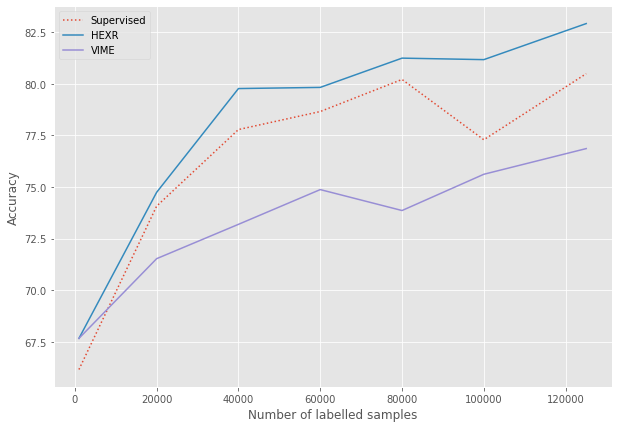

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

number_data = [1000,20000,40000,60000,80000,100000, len(label_idx)]

#LOADING THE ACCURACIES FROM HEXR EXPERIMENT NOTEBOOK TO COMPARE WITH VIME.
self_supervised_acc = np.array([0.67658763, 0.74743025, 0.79776019, 0.79832218, 0.812517  , 0.81179185, 0.82928156])
mlp_supervised_acc = np.array([0.6614818440564891,
 0.7407316763655482,
 0.7778774859048966,
 0.7866155435905803,
 0.8021745436087091,
 0.7729283370497272,
 0.8049799677308244])

plt.figure(figsize = (10,7))
plt.xlabel("Number of labelled samples")
plt.ylabel("Accuracy")
#plt.plot(number_data, mlp_supervised_acc*100, ':', label = "Supervised")
plt.plot(number_data, np.array(mlp_supervised_acc)*100, ':', label = "Supervised")
plt.plot(number_data, self_supervised_acc*100, label = "HEXR")
plt.plot(number_data, np.array(orig_vime_self_acc)*100, label = "VIME")
plt.legend()

## Valence

In [ ]:
#Run this cell for CASE

df = pd.read_csv('/content/drive/MyDrive/HEXR/Data/CASE_2class.csv')

ohe = OneHotEncoder()
#Choose either class1 or class2 to select either valence or arousal
df_ohe = pd.DataFrame(ohe.fit_transform(df[['class1']]).toarray())
df = df.join(df_ohe)

df.drop('class1', axis=1, inplace=True)
df.drop('class2', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('valence', axis=1, inplace=True)
df.drop('arousal', axis=1, inplace=True)
X = df.loc[:,:'emg_trap']
y = df.iloc[:,8:]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X[['ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']] = scaler.fit_transform(X[['ecg', 'bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']])


from sklearn.model_selection import train_test_split

"""
Split used in accordance with VIME @ Neurips 2020 for comparison:
15% :- Test 
10% of 85% = 8.5% :- Labelled dataset
90% of 85% = 76.5% :- Unlabelled dataset
"""
X_L, X_U, y_L, y_test = train_test_split(X,y,test_size=0.15,random_state=7) 

#converting to numpy arrays
X_L = X_L.iloc[:, :].values
y_L = y_L.iloc[:, :].values
X_U = X_U.iloc[:,:].values
y_test = y_test.iloc[:,:].values
X_L.shape, X_U.shape, y_L.shape, y_test.shape


x_train = X_L
y_train = y_L
x_test = X_U
y_test = y_test

In [ ]:
# Experimental parameters
label_no = 1000  
model_sets = ['logit','mlp']

#reconstuction loss is log cosh
#recon_loss = log_cosh

# Hyper-parameters
p_m = 0.3
alpha = 2.0
K = 3
beta = 1.0
label_data_rate = 0.1

# Metric
metric1 = 'acc'
metric2 = 'auc'
  
# Define output
results = np.zeros([len(model_sets)+2])

In [ ]:
# Divide labeled and unlabeled data
idx = np.random.permutation(len(y_train))

# Label data : Unlabeled data = label_data_rate:(1-label_data_rate)
label_idx = idx[:int(len(idx)*label_data_rate)]
unlab_idx = idx[int(len(idx)*label_data_rate):]

# Unlabeled data
x_unlab = x_train[unlab_idx, :]

# Labeled data
x_train = x_train[label_idx, :] 
y_train = y_train[label_idx, :]

In [ ]:
len(x_unlab)

1125285

In [ ]:
# Self supervised training of encoder - 90% of train data.

mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 128
  
# Train VIME-Self
vime_self_parameters = dict()
vime_self_parameters['batch_size'] = 128
vime_self_parameters['epochs'] = 15
vime_self_encoder = vime_self(x_unlab, p_m, alpha, vime_self_parameters)
    
# Save encoder
if not os.path.exists('save_model'):
  os.makedirs('save_model')

file_name = '../save_model/CASE_encoder_valence.h5'
    
vime_self_encoder.save(file_name)  

Epoch 1/15
8792/8792 [==============================] - 33s 4ms/step - loss: 0.6339 - mask_loss: 0.6125 - feature_loss: 0.0107
Epoch 2/15
8792/8792 [==============================] - 32s 4ms/step - loss: 0.6264 - mask_loss: 0.6106 - feature_loss: 0.0079
Epoch 3/15
8792/8792 [==============================] - 30s 3ms/step - loss: 0.6262 - mask_loss: 0.6104 - feature_loss: 0.0079
Epoch 4/15
8792/8792 [==============================] - 30s 3ms/step - loss: 0.6262 - mask_loss: 0.6104 - feature_loss: 0.0079
Epoch 5/15
8792/8792 [==============================] - 31s 4ms/step - loss: 0.6262 - mask_loss: 0.6104 - feature_loss: 0.0079
Epoch 6/15
8792/8792 [==============================] - 30s 3ms/step - loss: 0.6261 - mask_loss: 0.6104 - feature_loss: 0.0079
Epoch 7/15
8792/8792 [==============================] - 30s 3ms/step - loss: 0.6245 - mask_loss: 0.6087 - feature_loss: 0.0079
Epoch 8/15
8792/8792 [==============================] - 31s 4ms/step - loss: 0.6235 - mask_loss: 0.6078 - featu

In [ ]:
logistic_supervised_acc = []
logistic_supervised_auc = []
mlp_supervised_acc = []
mlp_supervised_auc = []
self_supervised_acc = []
self_supervised_auc = []

mlp_parameters = dict()
mlp_parameters['hidden_dim'] = 100
mlp_parameters['epochs'] = 100
mlp_parameters['activation'] = 'relu'
mlp_parameters['batch_size'] = 128

# from keras.models import load_model
# vime_self_encoder = load_model('../save_model/CASE_encoder_valence.h5')

for label_no in tqdm([1000,20000,40000,60000,80000,100000, len(label_idx)]):
  x_t = x_train[:label_no, :]
  y_t = y_train[:label_no, :]  

  y_test_hat = logit(x_t, y_t, x_test)
  logistic_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
  logistic_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

  y_test_hat = mlp(x_t, y_t, x_test, mlp_parameters)
  mlp_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
  mlp_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

  # Test VIME-Self
  x_train_hat = vime_self_encoder.predict(x_t)
  x_test_hat = vime_self_encoder.predict(x_test)
        
  y_test_hat = mlp(x_train_hat, y_t, x_test_hat, mlp_parameters)
  self_supervised_acc.append(perf_metric(metric1, y_test, y_test_hat))
  self_supervised_auc.append(perf_metric(metric2, y_test, y_test_hat))

  0%|          | 0/7 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch: 28.
Epoch 78: early stopping


100%|██████████| 7/7 [29:05<00:00, 249.32s/it]


In [ ]:
# logistic_supervised_acc

[0.6795879335037436,
 0.6766963978172984,
 0.6766012218777759,
 0.6764335309367125,
 0.6764833850002719,
 0.6763791446855568,
 0.6765332390638313]

In [ ]:
# mlp_supervised_auc

[0.6294707808777823,
 0.7750982561010138,
 0.829857962936672,
 0.8421998206210648,
 0.8640369392360756,
 0.8682568521240643,
 0.8666504009550444]

In [ ]:
# mlp_supervised_acc

[0.6614818440564891,
 0.7407316763655482,
 0.7778774859048966,
 0.7866155435905803,
 0.8021745436087091,
 0.7729283370497272,
 0.8049799677308244]

In [ ]:
# self_supervised_auc

[0.5434188082097144,
 0.7829642232904042,
 0.857144924052031,
 0.862785287505124,
 0.8778236031770685,
 0.8742225672487993,
 0.8945101437598828]

In [ ]:
# self_supervised_acc

array([0.67658763, 0.74743025, 0.79776019, 0.79832218, 0.812517  ,
       0.81179185, 0.82928156])

In [ ]:
orig_vime_self_acc = self_supervised_acc
orig_vime_self_auc = self_supervised_auc
orig_vime_sup_acc = mlp_supervised_acc
orig_vime_sup_auc = mlp_supervised_auc
orig_vime_logistic = logistic_supervised_acc

In [ ]:
orig_vime_self_acc

[0.6874331502329545,
 0.7100034444625732,
 0.7236634578778485,
 0.7351525534344917,
 0.7397345950943601,
 0.746845597432969,
 0.7566804445169595]

In [ ]:
orig_vime_sup_acc

[0.6883033302514457,
 0.738574355069705,
 0.7515137506571672,
 0.769610775729229,
 0.7863164192092239,
 0.7887456717608455,
 0.7949321078298073]

In [ ]:
hexr_self_supervised_acc = [0.6874331502329545,
 0.7386287413208608,
 0.7526150722430703,
 0.7896249161545295,
 0.8019841917296641,
 0.8022833161110204,
 0.8177969942531861]

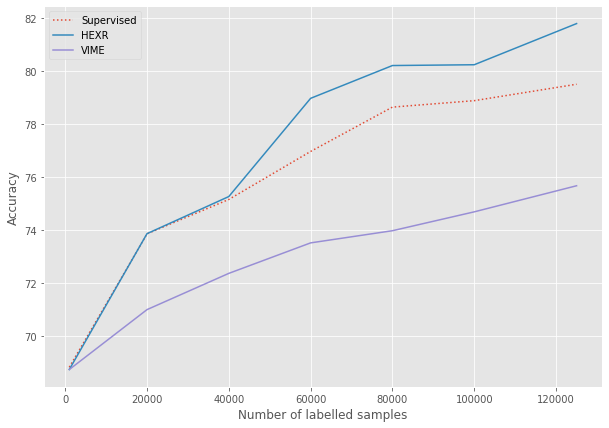

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

number_data = [1000,20000,40000,60000,80000,100000, len(label_idx)]
# self_supervised_acc = np.array([0.67658763, 0.74743025, 0.79776019, 0.79832218, 0.812517  , 0.81179185, 0.82928156])
# mlp_supervised_acc = np.array([0.6614818440564891,
#  0.7407316763655482,
#  0.7778774859048966,
#  0.7866155435905803,
#  0.8021745436087091,
#  0.7729283370497272,
#  0.8049799677308244])

plt.figure(figsize = (10,7))
plt.xlabel("Number of labelled samples")
plt.ylabel("Accuracy")
#plt.plot(number_data, mlp_supervised_acc*100, ':', label = "Supervised")
plt.plot(number_data, np.array(orig_vime_sup_acc)*100, ':', label = "Supervised")
plt.plot(number_data, np.array(hexr_self_supervised_acc)*100, label = "HEXR")
plt.plot(number_data, np.array(orig_vime_self_acc)*100, label = "VIME")
plt.legend()